# Метод UMAP для визуализации данных и понижения размерности

#### UMAP (Uniform Manifold Approximation and Projection) — это новый алгоритм уменьшения размерности, библиотека с реализацией которого вышла совсем недавно. Авторы алгоритма считают, что UMAP способен бросить вызов современным моделям снижения размерности, в частности, t-SNE, который на сегодняшний день является наиболее популярным. По результатам их исследований, у UMAP нет ограничений на размерность исходного пространства признаков, которое необходимо уменьшить, он намного быстрее и более вычислительно эффективен, чем t-SNE, а также лучше справляется с задачей переноса глобальной структуры данных в новое, уменьшенное пространство.

### Принцип работы алгоритма


На обработку алгоритму поступает выборка из n объектов: X={x1,…,xn}. UMAP рассчитывает расстояние между объектами по заданной метрике и для каждого объекта xi определяет список из его kk ближайших соседей: T={t1,...,tk}
Помимо этого, для каждого объекта рассчитывается расстояние до его ближайшего соседа: $${\displaystyle \rho _{i}=\min _{t\,\in \,T}d(x_{i},t)}.$$
А также величина σi, заданная уравнением:
$${\displaystyle \sum _{t\,\in \,T}\exp \left(-{\frac {d(x_{i},t)-\rho _{i}}{\sigma _{i}}}\right)=\log _{2}k}.$$

Далее алгоритм выполняет построение взвешенного ориентированного графа, в котором ребра соединяют каждый объект с его соседями. Вес ребра от $$x_{i}$$ объекта до его $$t_{j}$$  соседа рассчитывается следующим образом:
$${\displaystyle w(x_{i}\rightarrow t_{j})=\exp \left(-{\frac {d(x_{i},t_{j})-\rho _{i}}{\sigma _{i}}}\right)}$$

Полученная ранее $$\sigma_i$$ нормирует сумму весов для каждого объекта к заданному числу $${\displaystyle \log _{2}k}.$$

Так как UMAP строит взвешенный ориентированный граф, то между вершинами могут существовать два ребра с разными весами. Вес ребра интерпретируется как вероятность существования данного ребра от одного объекта к другому. Исходя из этого, ребра между двумя вершинами объединяются в одно с весом, равным вероятности существования хотя бы одного ребра:
$${\displaystyle w(x_{i},x_{j})=w(x_{i}\rightarrow x_{j})+w(x_{j}\rightarrow x_{i})-w(x_{i}\rightarrow x_{j})\cdot w(x_{j}\rightarrow x_{i})}$$
Таким образом, алгоритм получает взвешенный неориентированный граф

Множество ребер E такого графа является нечетким множеством из случайных величин Бернулли. Алгоритм создает новый граф в низкоразмерном пространстве и приближает множество его ребер к исходному. Для этого он минимизирует сумму дивергенций Кульбака-Лейблера для каждого ребра 
e из исходного и нового нечетких множеств:
$${\displaystyle \sum _{e\in E}w_{h}(e)\log {\frac {w_{h}(e)}{w_{l}(e)}}+(1-w_{h}(e))\log \left({\frac {1-w_{h}(e)}{1-w_{l}(e)}}\right)\rightarrow \min _{w_{l}}}$$
$${\displaystyle w_{h}(e)}$$ — функция принадлежности нечеткого множества из ребёр в высокоразмерном пространстве,
$${\displaystyle w_{l}(e)}$$ — функция принадлежности нечеткого множества из ребёр в низкоразмерном пространстве.

Итак, теперь попробуем применить UMAP к какому-нибудь набору данных и сравним его качество визуализации с t-SNE. Наш выбор пал на датасет Fashion MNIST, который включает в себя 70000 черно-белых изображений различной одежды по 10 классам: футболки, брюки, свитеры, платья, кроссовки и т.д. Каждая картинка имеет размер 28x28 пикселей или 784 пикселя всего. Они и будут являться фичами в нашей модели.


Попробуем использовать библиотеку UMAP на Python для того, чтобы представить наши предметы одежды на двумерной плоскости. Зададим количество соседей, равное 5, а остальные параметры оставим по умолчанию. Их мы обсудим чуть позже.

In [32]:
import pandas as pd
import umap
fmnist = pd.read_csv('fashion-mnist.csv') # считываем данные
embedding = umap.UMAP(n_neighbors=5).fit_transform(fmnist.drop('label', axis=1)) # преобразовываем

Результатом преобразования стали два вектора той же длины, что и исходный датасет. Визуализируем эти вектора и посмотрим, насколько хорошо алгоритму удалось сохранить структуру данных:


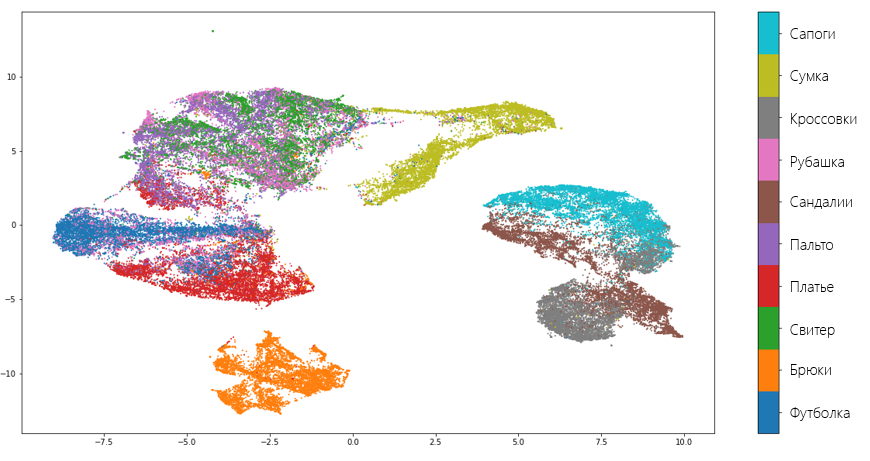

Как видно, алгоритм справляется вполне хорошо и «не растерял» большинство ценной информации, которая отличает один вид одежды от другого. Также о качестве алгоритма говорит и тот факт, что UMAP отделил обувь, одежду для туловища и брюки друг от друга, понимая, что это совершенно разные вещи. Конечно, есть и ошибки. К примеру, модель решила, что рубашка и свитер — это одно и то же. 

Теперь посмотрим, как с этим же набором данных управится t-SNE. Для этого будем использовать Multicore TSNE — самую быструю (даже в режиме одного ядра) среди всех реализаций алгоритма:

In [ ]:
from MulticoreTSNE import MulticoreTSNE as TSNE

tsne = TSNE()
embedding_tsne = tsne.fit_transform(fmnist.drop('label', axis = 1))


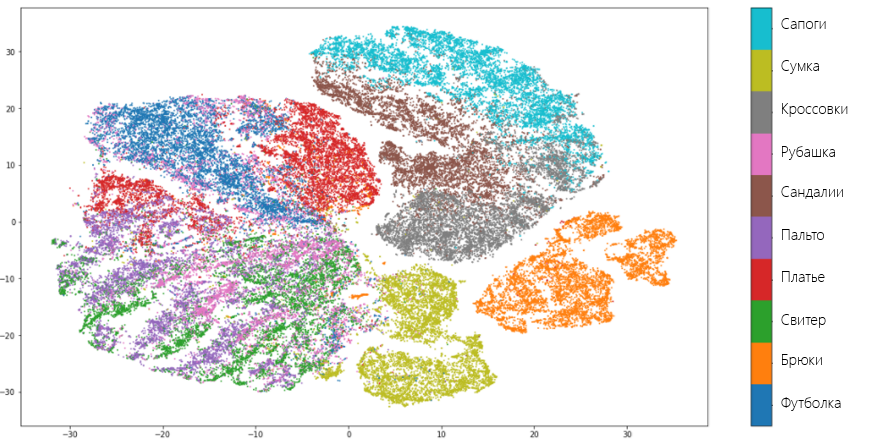

T-SNE показывает схожие с UMAP результаты и допускает те же ошибки. Однако, в отличии от UMAP, t-SNE не так очевидно объединяет виды одежды в отдельные группы: брюки, вещи для туловища и для ног находятся близко друг к другу. Однако в целом можно сказать, что оба алгоритма одинаково хорошо справились с задачей и исследователь волен на свой вкус делать выбор в пользу одного или другого. Можно было, если бы не одно «но».

Это «но» заключается в скорости обучения. На сервере с 4 ядрами Intel Xeon E5- 2690v3, 2,6 Гц и 16 Гб оперативной памяти на наборе данных размера 70000х784 UMAP обучился за 4 минуты и 21 секунду, в то время как t-SNE потребовалось на это почти в 5 раз больше времени: 20 минут, 14 секунд. То есть UMAP значительно более вычислительно эффективен, что дает ему огромное преимущество перед другими алгоритмами, в том числе и перед t-SNE.

### Параметры алгоритма

##### Число соседей — n_neighbors.

Варьируя этот параметр, можно выбирать, что важнее сохранить в новом пространственном представлении данных: глобальную или локальную структуру данных. Маленькие значения параметра означают, что, пытаясь оценить пространство, в котором распределены данные, алгоритм ограничивается малой окрестностью вокруг каждой точки, то есть пытается уловить локальную структуру данных (возможно в ущерб общей картине). С другой стороны большие значения n_neighbors заставляют UMAP учитывать точки в большей окрестности, сохраняя глобальную структуру данных, но упуская детали.

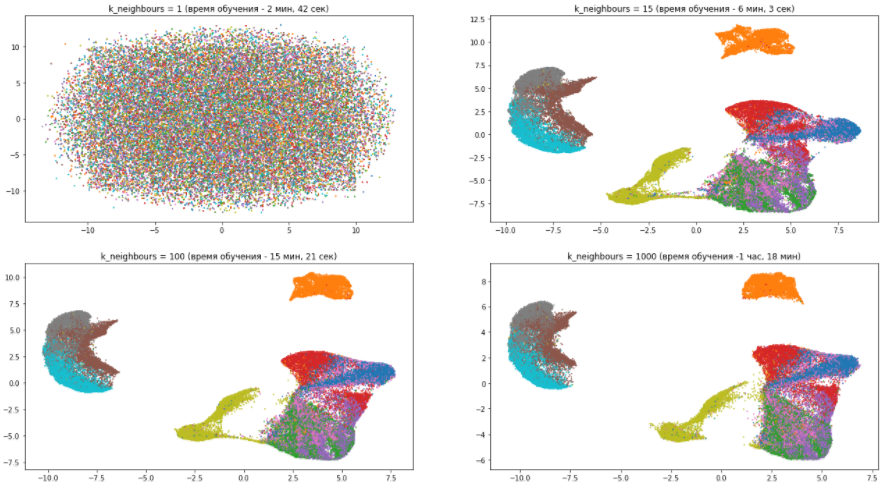

Из данной картины можно сделать следующие несколько выводов:

С количеством соседей, равным единице, алгоритм работает просто ужасно, поскольку слишком сильно фокусируется на деталях и попросту не может уловить общую структуру данных.
С ростом количества соседей модель все меньше внимания уделяет различиям между разными видами одежды, группируя похожие и смешивая их между собой. В то же время абсолютно разные предметы гардероба становятся все дальше друг от друга. Как уже было сказано, общая картина становится ясней, а детали размываются.
Параметр n_neighbors значительно влияет на время обучения. поэтому нужно аккуратно подходить к его подбору.

### Минимальное расстояние — min_dist.

Данный параметр стоит понимать буквально: он определяет минимальное расстояние, на котором могут находиться точки в новом пространстве. Низкие значения стоит применять в случае, если вас интересует, на какие кластеры разделяются ваши данные, а высокие — если вам важнее взглянуть на структуру данных, как единого целого.



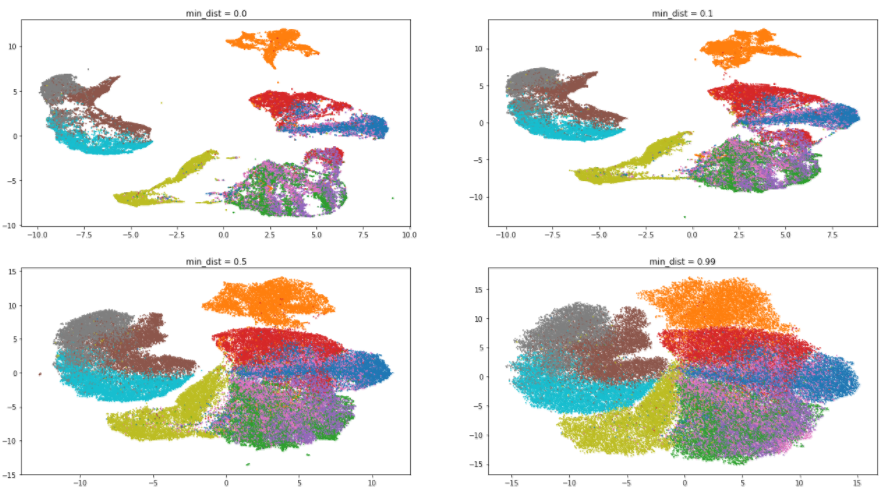

Как и ожидалось, увеличение значения параметра приводит к меньшей степени кластеризации, данные собираются в кучу и различия между ними стираются. Интересно, что при минимальном значении min_dist алгоритм пытается найти различия внутри кластеров и разделить их на еще более мелкие группы.

### Метрика расстояния — metric.

 Параметр metric определяет, каким образом будут рассчитаны расстояния в пространстве исходных данных. По умолчанию UMAP поддерживает всевозможные расстояния, от Минковского до Хэмминга. Выбор метрики зависит от того, как мы интерпретируем эти данные и их типа. К примеру, работая с текстовой информацией, предпочтительно использовать косинусное расстояние (metric='cosine').

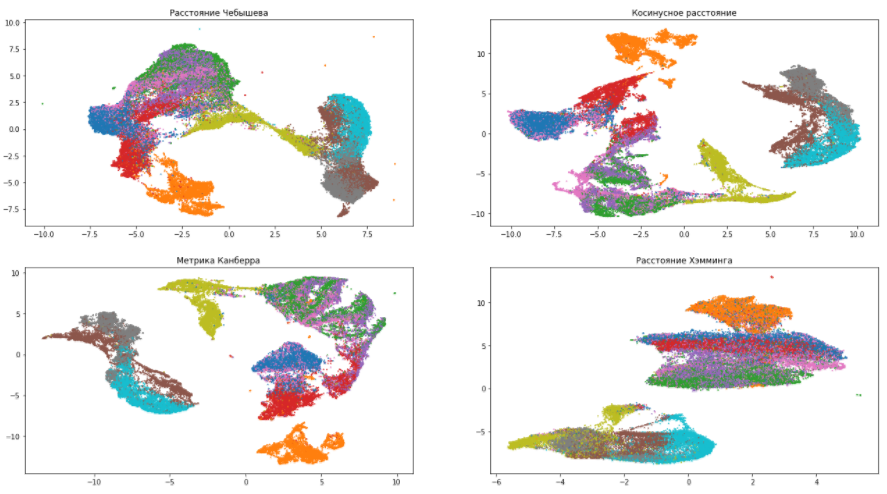

По данным картинкам можно убедиться, что выбор меры расстояния очень сильно влияет на итоговый результат, поэтому, к ее выбору нужно подходить ответственно. Если же вы не уверены, какую метрику из всего многообразия выбрать, то расстояние Евклида является наиболее безопасным вариантом (стоит по умолчанию в UMAP).

### Размерность конечного пространства — n_components.

Тут все очевидно: параметр определяет размерность итогового пространства. Если вам нужно визуализировать данные, то следует выбирать 2 или 3. Если же использовать преобразованные вектора в качестве фич моделей машинного обучения, то можно и больше.
